# Sentiment Identification

## BACKGROUND

A large multinational corporation is seeking to automatically identify the sentiment that their customer base talks
about on social media. They would like to expand this capability into multiple languages. Many 3rd party tools exist for sentiment analysis, however, they need help with under-resourced languages.

## GOAL

Train a sentiment classifier (Positive, Negative, Neutral) on a corpus of the provided documents. Your goal is to
maximize accuracy. There is special interest in being able to accurately detect negative sentiment. The training data
includes documents from a wide variety of sources, not merely social media, and some of it may be inconsistently
labeled. Please describe the business outcomes in your work sample including how data limitations impact your results
and how these limitations could be addressed in a larger project.

## DATA
Link to data: http://archive.ics.uci.edu/ml/datasets/Roman+Urdu+Data+Set

In [46]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_colwidth', None)

## Data Exploration

In [47]:
import emoji
import functools
import operator
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import spacy
import string
import re
import os
import tensorflow as tf
from tensorflow import keras
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
DATA_DIR = os.path.abspath('../data/raw')

In [48]:
data_path = os.path.join(DATA_DIR, 'Roman Urdu Dataset.csv')
raw_df = pd.read_csv(data_path, skipinitialspace=True, names=['comment', 'sentiment', 'nan'], encoding='utf-8')
raw_df.tail()

,comment,sentiment,nan
20224,Hamari jese awam teli laga k mazay leti,Negative,NaN
20225,Kaash hum b parhay likhay hotayKabhi likhtay gulbadanKabhi likhtay Gulfeezan,Negative,NaN
20226,Bahi sayasat kufrrr ha saaaf bttttt ha qanon sirf Allah ka Calhay ga Muslim country me sayasat ka kaaaam isreal ka ha,Negative,NaN
20227,aanti toh gussa e kr gai hain,Negative,NaN
20228,mai b sirf shadi kanry ki waja say imran khan ka sat dey raha hun,Positive,NaN


In [49]:
#Print a concise summary of a DataFrame.
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20229 entries, 0 to 20228
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   comment    20116 non-null  object
 1   sentiment  20229 non-null  object
 2   nan        7 non-null      object
dtypes: object(3)
memory usage: 474.2+ KB


In [50]:
# Check missing data
raw_df.isnull().sum()

comment        113
sentiment        0
nan          20222
dtype: int64

In [51]:
# For each column of the dataframe, we want to know numbers of unique attributes and the attributes values.
for column in raw_df.columns:
    unique_attribute = (raw_df[column].unique())
    print('{0:20s} {1:5d}\t'.format(column, len(unique_attribute)), unique_attribute[0:10])

comment              19619	 ['Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus'
 'sahi bt h' 'Kya bt hai,' 'Wah je wah' 'Are wha kaya bat hai'
 'Wah kya baat likhi' 'Wha Itni sari khubiya' 'Itni khubiya'
 'Ya allah rehm farma hm sab pe or zalimo ko hidayat de ameen'
 'Please Everyone AllAh S.w.T ka naam hAmesha Bary Lawzo main Likha kary Wo he Zaat sUb say Bari Hey']
sentiment                4	 ['Positive' 'Neutral' 'Negative' 'Neative']
nan                      7	 [nan '----------------' '----------' '-------' '------' '9090' 'till here']


## Initial Data Preprocessing
     -- Drop the NaN column
     -- Replace "Neative" - > "Negative"

In [52]:
cleaned_df = raw_df.copy()
cleaned_df.drop('nan',axis=1,inplace=True)
cleaned_df.dropna(axis=0, subset = ['comment'], inplace=True)
cleaned_df.replace(to_replace='Neative', value='Negative', inplace=True)
cleaned_df.dropna(subset=['sentiment'], inplace=True)

cleaned_df.head(5)

,comment,sentiment
0,Sai kha ya her kisi kay bus ki bat nhi hai lakin main ki hal kal bi Aj aur aj bi sirf Aus say bus,Positive
1,sahi bt h,Positive
2,"Kya bt hai,",Positive
3,Wah je wah,Positive
4,Are wha kaya bat hai,Positive


## Examine the class label imbalance

In [53]:
print(f'There are total {cleaned_df.shape[0]} comments')
print(f'There are {cleaned_df[cleaned_df["sentiment"] == "Positive"].shape[0]} Positive comments')
print(f'There are {cleaned_df[cleaned_df["sentiment"] == "Neutral"].shape[0]} Neutral comments')
print(f'There are {cleaned_df[cleaned_df["sentiment"] == "Negative"].shape[0]} Negative comments')

There are total 20116 comments
There are 6013 Positive comments
There are 8816 Neutral comments
There are 5287 Negative comments


# Data Preprocessing:

### 1.  Encode the Labels

### 2.  Tokenization:
    -- Applied lower case for each token 
    -- remove 0-9 numeric 
    -- remove the punctuation
    -- (TO DO) Remove stop words
### 3.  Train, Val, Test split

    

In [54]:
# Encode the output labels: 
    # Negative -> 0
    # Neutral -> 1
    # Positive -> 2

le = LabelEncoder()
le.fit(cleaned_df['sentiment'])
cleaned_df['sentiment']= le.transform(cleaned_df['sentiment'])

In [55]:
# tokenize for a single document
def tokenizer(doc):
    """ Tokenize a single document"""
    tokens = [word.lower() for word in nltk.word_tokenize(doc)]
    tokens = [re.sub(r'[0-9]', '', word) for word in tokens]
    tokens = [re.sub(r'['+string.punctuation+']', '', word) for word in tokens]   
    tokens = ' '.join(tokens)
    
    em_split_emoji = emoji.get_emoji_regexp().split(tokens)
    em_split_whitespace = [substr.split() for substr in em_split_emoji]
    em_split = functools.reduce(operator.concat, em_split_whitespace)        
    tokens = ' '.join(em_split)
    return tokens

cleaned_df['comment'] = cleaned_df['comment'].apply(lambda x: tokenizer(x))

In [56]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2,random_state=40)

train_labels = train_df['sentiment']
test_labels = test_df['sentiment']
train_features = train_df['comment']
test_features = test_df['comment']


# Gridsearch Pipeline: LogisticRegression

### TF-IDF


In [57]:
from typing import Any, List, Tuple
def vectorize(train_texts: List[str], train_labels, test_texts: List[str]) -> Tuple[Any, Any]:
    """ Convert the document into word n-grams and vectorize it

    :param train_texts: of training texts
    :param train_labels: An array of labels from the training dataset
    :param test_texts: List of test texts
    :return: A tuple of vectorize training_text and vectorize test texts
    """

    kwargs = {
        'ngram_range': (1, 2),
        'analyzer': 'word',
        'min_df': MIN_DOCUMENT_FREQUENCY
    }
    # Use TfidfVectorizer to convert the raw documents to a matrix of TF-IDF features
    #
    vectorizer = TfidfVectorizer(**kwargs)
    X_train = vectorizer.fit_transform(train_texts)
    X_test = vectorizer.transform(test_texts)
    selector = SelectKBest(f_classif, k=min(30000, X_train.shape[1]))
    selector.fit(X_train, train_labels)
    X_train = selector.transform(X_train)
    X_test = selector.transform(X_test)

    return X_train, X_test

In [58]:
from sklearn.ensemble import GradientBoostingClassifier

NGRAM_RANGE = (1, 2)
TOKEN_MODE = 'word'
MIN_DOCUMENT_FREQUENCY = 2

X_train, X_test = vectorize(train_features, train_labels, test_features)

# gridsearch
lr_tfidf = Pipeline([
           ('clf', LogisticRegression(random_state=40, solver = 'saga'))
       ])

C_OPTIONS = [1, 3, 5, 7, 10]

param_grid = [
    {
        'clf__penalty': ['l1', 'l2'],
        'clf__C': C_OPTIONS
    }
]

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [59]:
gs_lr_tfidf.fit(X_train, train_labels)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   47.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.7min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('clf',
                                        LogisticRegression(random_state=40,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1, 3, 5, 7, 10],
                          'clf__penalty': ['l1', 'l2']}],
             scoring='accuracy', verbose=2)

In [60]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 3, 'clf__penalty': 'l2'} 
CV Accuracy: 0.663


In [61]:
clf_lr = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf_lr.score(X_test, test_labels))

Test Accuracy: 0.662


In [62]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

y_pred_lr_tfidf = gs_lr_tfidf.predict(X_test)
y_test_exp = test_labels.to_numpy()
print('Precision Test for model: {}' .format(precision_score(y_test_exp, y_pred_lr_tfidf, average=None)))
print('Recall Test for model: {}' .format(recall_score(test_labels, y_pred_lr_tfidf, average=None)))
print('F1 Test for model: {}' .format(f1_score(test_labels, y_pred_lr_tfidf, average=None)))
print('Confusion matrix (Test):')
print(confusion_matrix(test_labels, y_pred_lr_tfidf))

Precision Test for model: [0.6289445  0.67855323 0.65936953]
Recall Test for model: [0.54890788 0.74164811 0.64085106]
F1 Test for model: [0.5862069  0.70869912 0.64997842]
Confusion matrix (Test):
[[ 578  341  134]
 [ 209 1332  255]
 [ 132  290  753]]


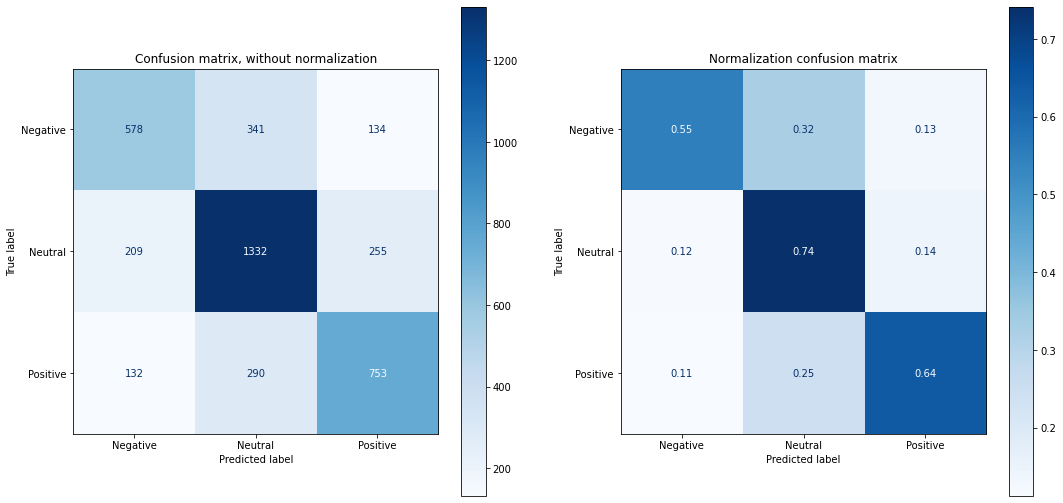

In [63]:
title_options = [("Confusion matrix, without normalization", None), 
                 ("Normalization confusion matrix", 'true')]
classes_names = np.array(['Negative', 'Neutral', 'Positive'])
fig = plt.figure(figsize=(18,9))
nrows=1
ncols=2

for idx,value in enumerate(title_options):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    disp= plot_confusion_matrix(clf_lr, X_test, test_labels,
                         display_labels=classes_names,
                         cmap=plt.cm.Blues,
                         normalize=value[1],
                               ax = ax)
    disp.ax_.set_title(value[0])


# Multiclass Classification - > Binary Clasification

Since the model can only accurately predict negative sentiment about ~50% of time, I want to see if I can improve upon this result.  One idea is to combine neutral sentiment and positive sentiment into one label and turn this analysis into a binary classification problem.

Since we have class imbalance issues when reforumlate to binary classifiaiton problems, use SMOTE to generate synthetic data within the minority class to have both classes have equal numbers of samples in training. The test accuracy improves from ~50% to ~70% on <b>negative sentiment </b>!

In [64]:
from imblearn.pipeline import Pipeline

In [65]:
# Combine the neutral/positive labels into one label -> 1
train_labels_binary = train_labels.map(lambda x: 1 if (x==2 or x==1) else 0)
test_labels_binary = test_labels.map(lambda x: 1 if (x==2 or x==1) else 0)

In [66]:
train_labels_binary.value_counts()

1    11858
0     4234
Name: sentiment, dtype: int64

In [67]:
# Class Imbalance Issues
print(f'There are {train_labels_binary.value_counts()[0]} that can be classified as negative sentiments')
print(f'There are {train_labels_binary.value_counts()[1]} that can be classified as non-negative sentiments' )

There are 4234 that can be classified as negative sentiments
There are 11858 that can be classified as non-negative sentiments


In [68]:
# tfidf = TfidfVectorizer(strip_accents=None,
#                         lowercase=False,
#                         preprocessor=None)

param_grid = [{'clf__penalty': ['l1', 'l2'],
               'clf__C': [0, 1, 3, 5, 7, 10]},
              ]

lr_tfidf = Pipeline([
           ('smote', SMOTE(sampling_strategy=1.0, random_state=5, k_neighbors=10)),
           ('clf', LogisticRegression(random_state=1, solver = 'saga'))
       ])

gs_lr_tfidf = GridSearchCV(lr_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [69]:
gs_lr_tfidf.fit(X_train, train_labels_binary)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  3.1min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(k_neighbors=10, random_state=5,
                                              sampling_strategy=1.0)),
                                       ('clf',
                                        LogisticRegression(random_state=1,
                                                           solver='saga'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [0, 1, 3, 5, 7, 10],
                          'clf__penalty': ['l1', 'l2']}],
             scoring='accuracy', verbose=2)

In [70]:
print('Best parameter set: %s ' % gs_lr_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_lr_tfidf.best_score_)

Best parameter set: {'clf__C': 10, 'clf__penalty': 'l2'} 
CV Accuracy: 0.733


In [71]:
clf_lr = gs_lr_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf_lr.score(X_test, test_labels_binary))

Test Accuracy: 0.724


In [72]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

y_pred_lr_tfidf = gs_lr_tfidf.predict(X_test)
y_test_exp_binary = test_labels_binary.to_numpy()
print('Precision Test for model: {}' .format(precision_score(y_test_exp_binary, y_pred_lr_tfidf, average=None)))
print('Recall Test for model: {}' .format(recall_score(test_labels_binary, y_pred_lr_tfidf, average=None)))
print('F1 Test for model: {}' .format(f1_score(test_labels_binary, y_pred_lr_tfidf, average=None)))
print('ROC AUC Train: %.3f for Logistic Regression' % roc_auc_score(y_test_exp_binary, y_pred_lr_tfidf, average=None))
print('Confusion matrix (Test):')
print(confusion_matrix(test_labels_binary, y_pred_lr_tfidf))

Precision Test for model: [0.47587899 0.83184577]
Recall Test for model: [0.55270655 0.78424773]
F1 Test for model: [0.51142355 0.80734581]
ROC AUC Train: 0.668 for Logistic Regression
Confusion matrix (Test):
[[ 582  471]
 [ 641 2330]]


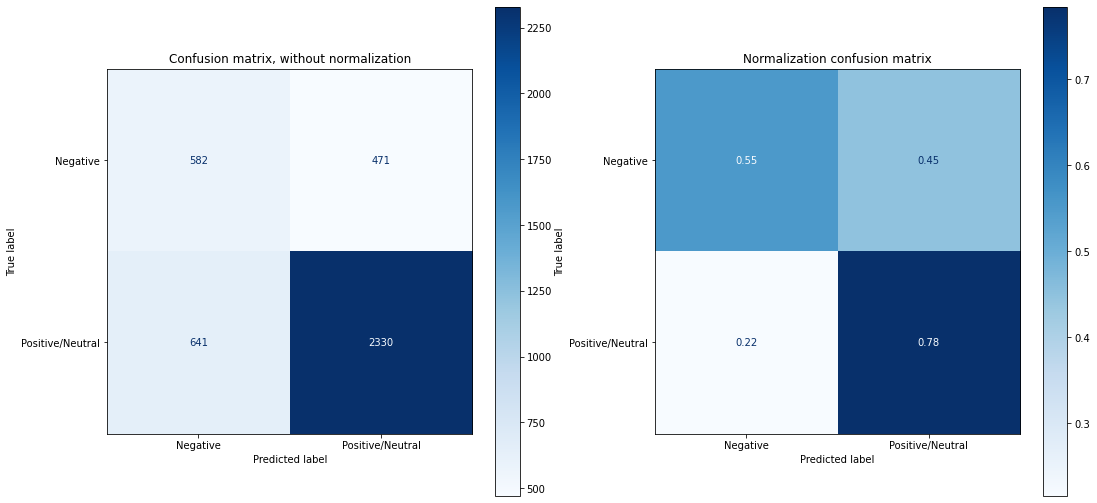

In [73]:
title_options = [("Confusion matrix, without normalization", None), 
                 ("Normalization confusion matrix", 'true')]
classes_names = np.array(['Negative', 'Positive/Neutral'])
fig = plt.figure(figsize=(18,9))
nrows=1
ncols=2

for idx,value in enumerate(title_options):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    disp= plot_confusion_matrix(clf_lr, X_test, test_labels_binary,
                         display_labels=classes_names,
                         cmap=plt.cm.Blues,
                         normalize=value[1],
                               ax = ax)
    disp.ax_.set_title(value[0])


# Gridsearch Pipeline: Naive Bayes


In [74]:
tfidf = TfidfVectorizer(strip_accents=None,
                        lowercase=False,
                        preprocessor=None)

param_grid = [
    {
        'clf__alpha': [0.25, 0.3, 0.35, 0.4, 0.45, 0.50]
    },  
]

nb_tfidf = Pipeline([
           #('vect', tfidf),
           ('smote', SMOTE(sampling_strategy=1.0, random_state=5, k_neighbors=3)),
           ('clf', MultinomialNB())
       ])

gs_nb_tfidf = GridSearchCV(nb_tfidf, param_grid,
                           scoring='accuracy',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

In [75]:
gs_nb_tfidf.fit(X_train, train_labels_binary)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    2.8s finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('smote',
                                        SMOTE(k_neighbors=3, random_state=5,
                                              sampling_strategy=1.0)),
                                       ('clf', MultinomialNB())]),
             n_jobs=-1,
             param_grid=[{'clf__alpha': [0.25, 0.3, 0.35, 0.4, 0.45, 0.5]}],
             scoring='accuracy', verbose=2)

In [76]:
print('Best parameter set: %s ' % gs_nb_tfidf.best_params_)
print('CV Accuracy: %.3f' % gs_nb_tfidf.best_score_)

Best parameter set: {'clf__alpha': 0.25} 
CV Accuracy: 0.739


In [77]:
clf_nb = gs_nb_tfidf.best_estimator_
print('Test Accuracy: %.3f' % clf_nb.score(X_test, test_labels_binary))

Test Accuracy: 0.716


In [78]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

y_pred_nb_tfidf = gs_nb_tfidf.predict(X_test)
y_test_exp_binary = test_labels_binary.to_numpy()
print('Precision Test for model: {}' .format(precision_score(y_test_exp_binary, y_pred_nb_tfidf, average=None)))
print('Recall Test for model: {}' .format(recall_score(test_labels_binary, y_pred_nb_tfidf, average=None)))
print('F1 Test for model: {}' .format(f1_score(test_labels_binary, y_pred_nb_tfidf, average=None)))
print('ROC AUC Train: %.3f for Naive Bayes' % roc_auc_score(y_test_exp_binary, y_pred_nb_tfidf, average=None))
print('Confusion matrix (Test):')
print(confusion_matrix(test_labels_binary, y_pred_nb_tfidf))

Precision Test for model: [0.47051199 0.86819831]
Recall Test for model: [0.68945869 0.72500841]
F1 Test for model: [0.55932203 0.79016875]
ROC AUC Train: 0.707 for Naive Bayes
Confusion matrix (Test):
[[ 726  327]
 [ 817 2154]]


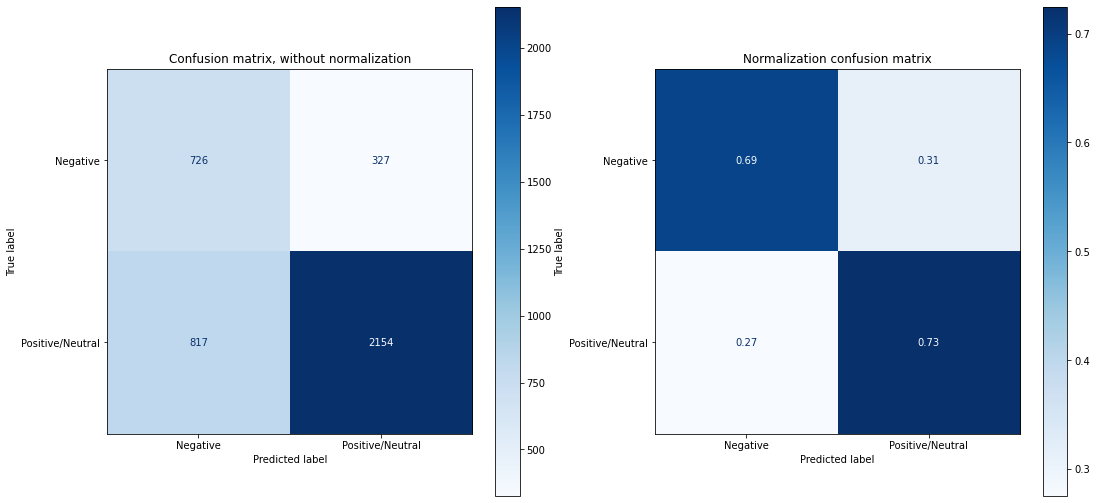

In [79]:
title_options = [("Confusion matrix, without normalization", None), 
                 ("Normalization confusion matrix", 'true')]
classes_names = np.array(['Negative', 'Positive/Neutral'])

fig = plt.figure(figsize=(18,9))
nrows=1
ncols=2

for idx,value in enumerate(title_options):
    ax = fig.add_subplot(nrows, ncols, idx+1)
    disp= plot_confusion_matrix(clf_nb, X_test, test_labels_binary,
                         #display_labels=sorted(test_labels_binary.unique()),
                         cmap=plt.cm.Blues,
                         display_labels=classes_names,
                         normalize=value[1],
                               ax = ax)
    disp.ax_.set_title(value[0])
